# Brand Analysis 

Analyze the outputs from the models to understand how we can leverage these predictions to come up with some insights 


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import altair as alt
alt.data_transformers.disable_max_rows()

import sys
sys.path.append("../scripts/")

In [2]:
from access_data import authenticate_google_drive, grab_google_drive_folder_data

drive = authenticate_google_drive()

# Load in data with embeddings
file_path = 'analyze_data.csv'
df  = grab_google_drive_folder_data(drive=drive, filename = file_path)

Successfully loaded 'analyze_data.csv' into a DataFrame!


In [3]:
# create negative flag
df['negativate_flag'] = np.where(df['open_ai_sentiment'] == 'Negative', 1, 0)

# Grouped by brand/search_query
data_brand_agg = df.groupby(by = 'search_query', as_index = False)\
                          .agg({'negativate_flag': 'mean'})


In [4]:
import base64
import altair as alt
import pandas as pd

from io import BytesIO
from PIL import Image

brands = ['Rocket Mortgage']
brand = brands[0]

image_paths = ["../images/brand_images/redfin_logo.png",
               "../images/brand_images/rkt_logo.png",
               "../images/brand_images/tt_logo.png",
               "../images/brand_images/uwm_logo.png",
               "../images/brand_images/wf_logo.webp",
               "../images/brand_images/xfinity_logo.png",
               "../images/brand_images/zillow_logo.png"]
base64_images = []
for image_path in image_paths:
    pil_image = Image.open(image_path)
    output = BytesIO()
    pil_image.save(output, format='PNG')
    base64_images.append(
        "data:image/png;base64," + base64.b64encode(output.getvalue()).decode()
    )

data_brand_agg['image'] = base64_images
# data_brand_agg['negativate_flag_nudged'] = data_brand_agg['negativate_flag'] + .032


In [5]:
data_brand_agg.head()

,search_query,negativate_flag,image
0,Redfin,0.335043,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
1,Rocket Mortgage,0.304895,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
2,Turbo Tax,0.347686,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
3,UWM,0.196078,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
4,Wells Fargo,0.394649,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."


In [6]:
brand_dict = {'Rocket Mortgage' : '#e74a51',
              'UWM': '#025f9f',
              'Redfin': '#c82020',
              'Zillow': '#0639d8',
              'Xfinity': '#5e34ef',
              'Turbo Tax': '#d02a1d',
              'Wells Fargo': '#f6c83f'}

In [7]:
# Table Shows values in the bar chart
data_brand_agg.sort_values(by='negativate_flag', ascending=False)[['search_query', 'negativate_flag']]

,search_query,negativate_flag
5,Xfinity,0.555789
4,Wells Fargo,0.394649
6,Zillow,0.379139
2,Turbo Tax,0.347686
0,Redfin,0.335043
1,Rocket Mortgage,0.304895
3,UWM,0.196078


alt.LayerChart(...)
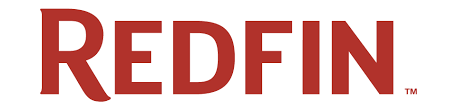
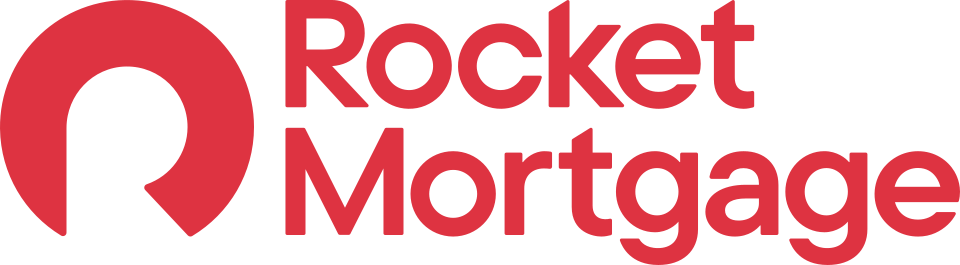
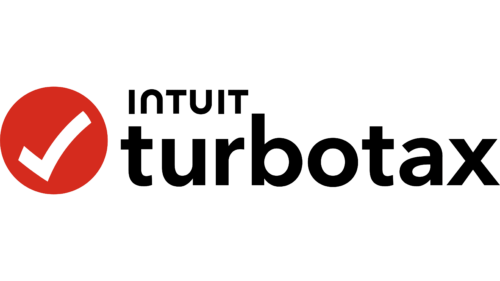
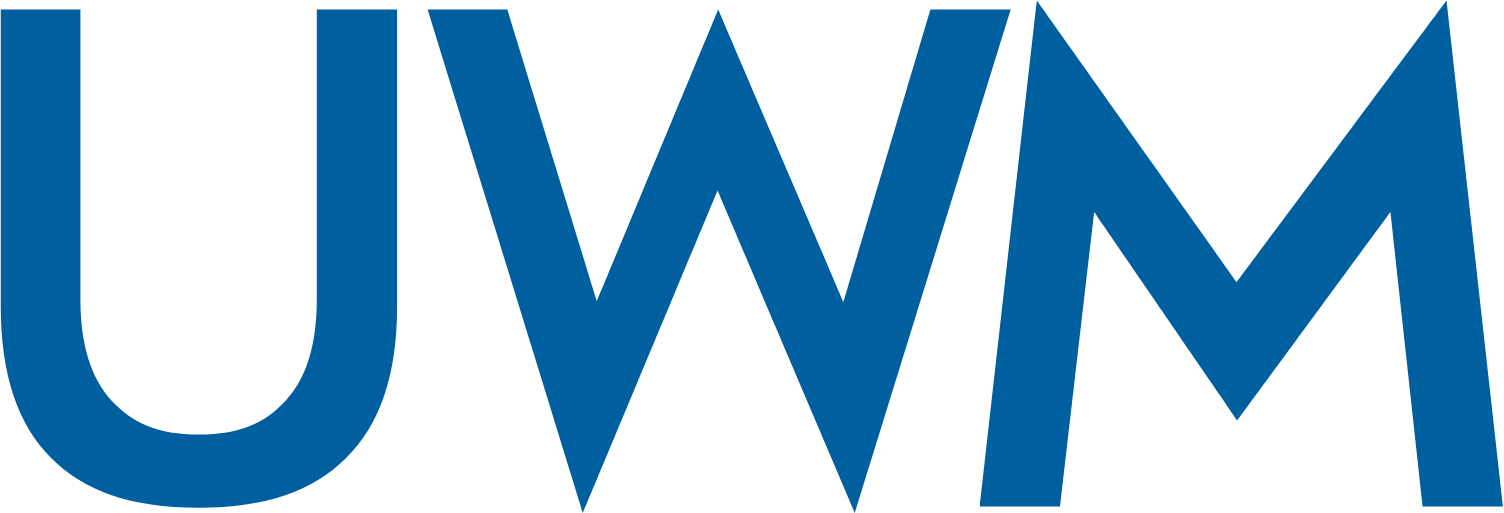
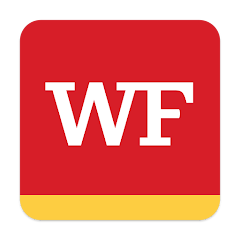
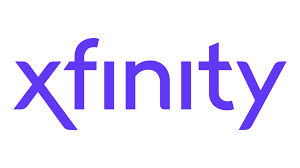
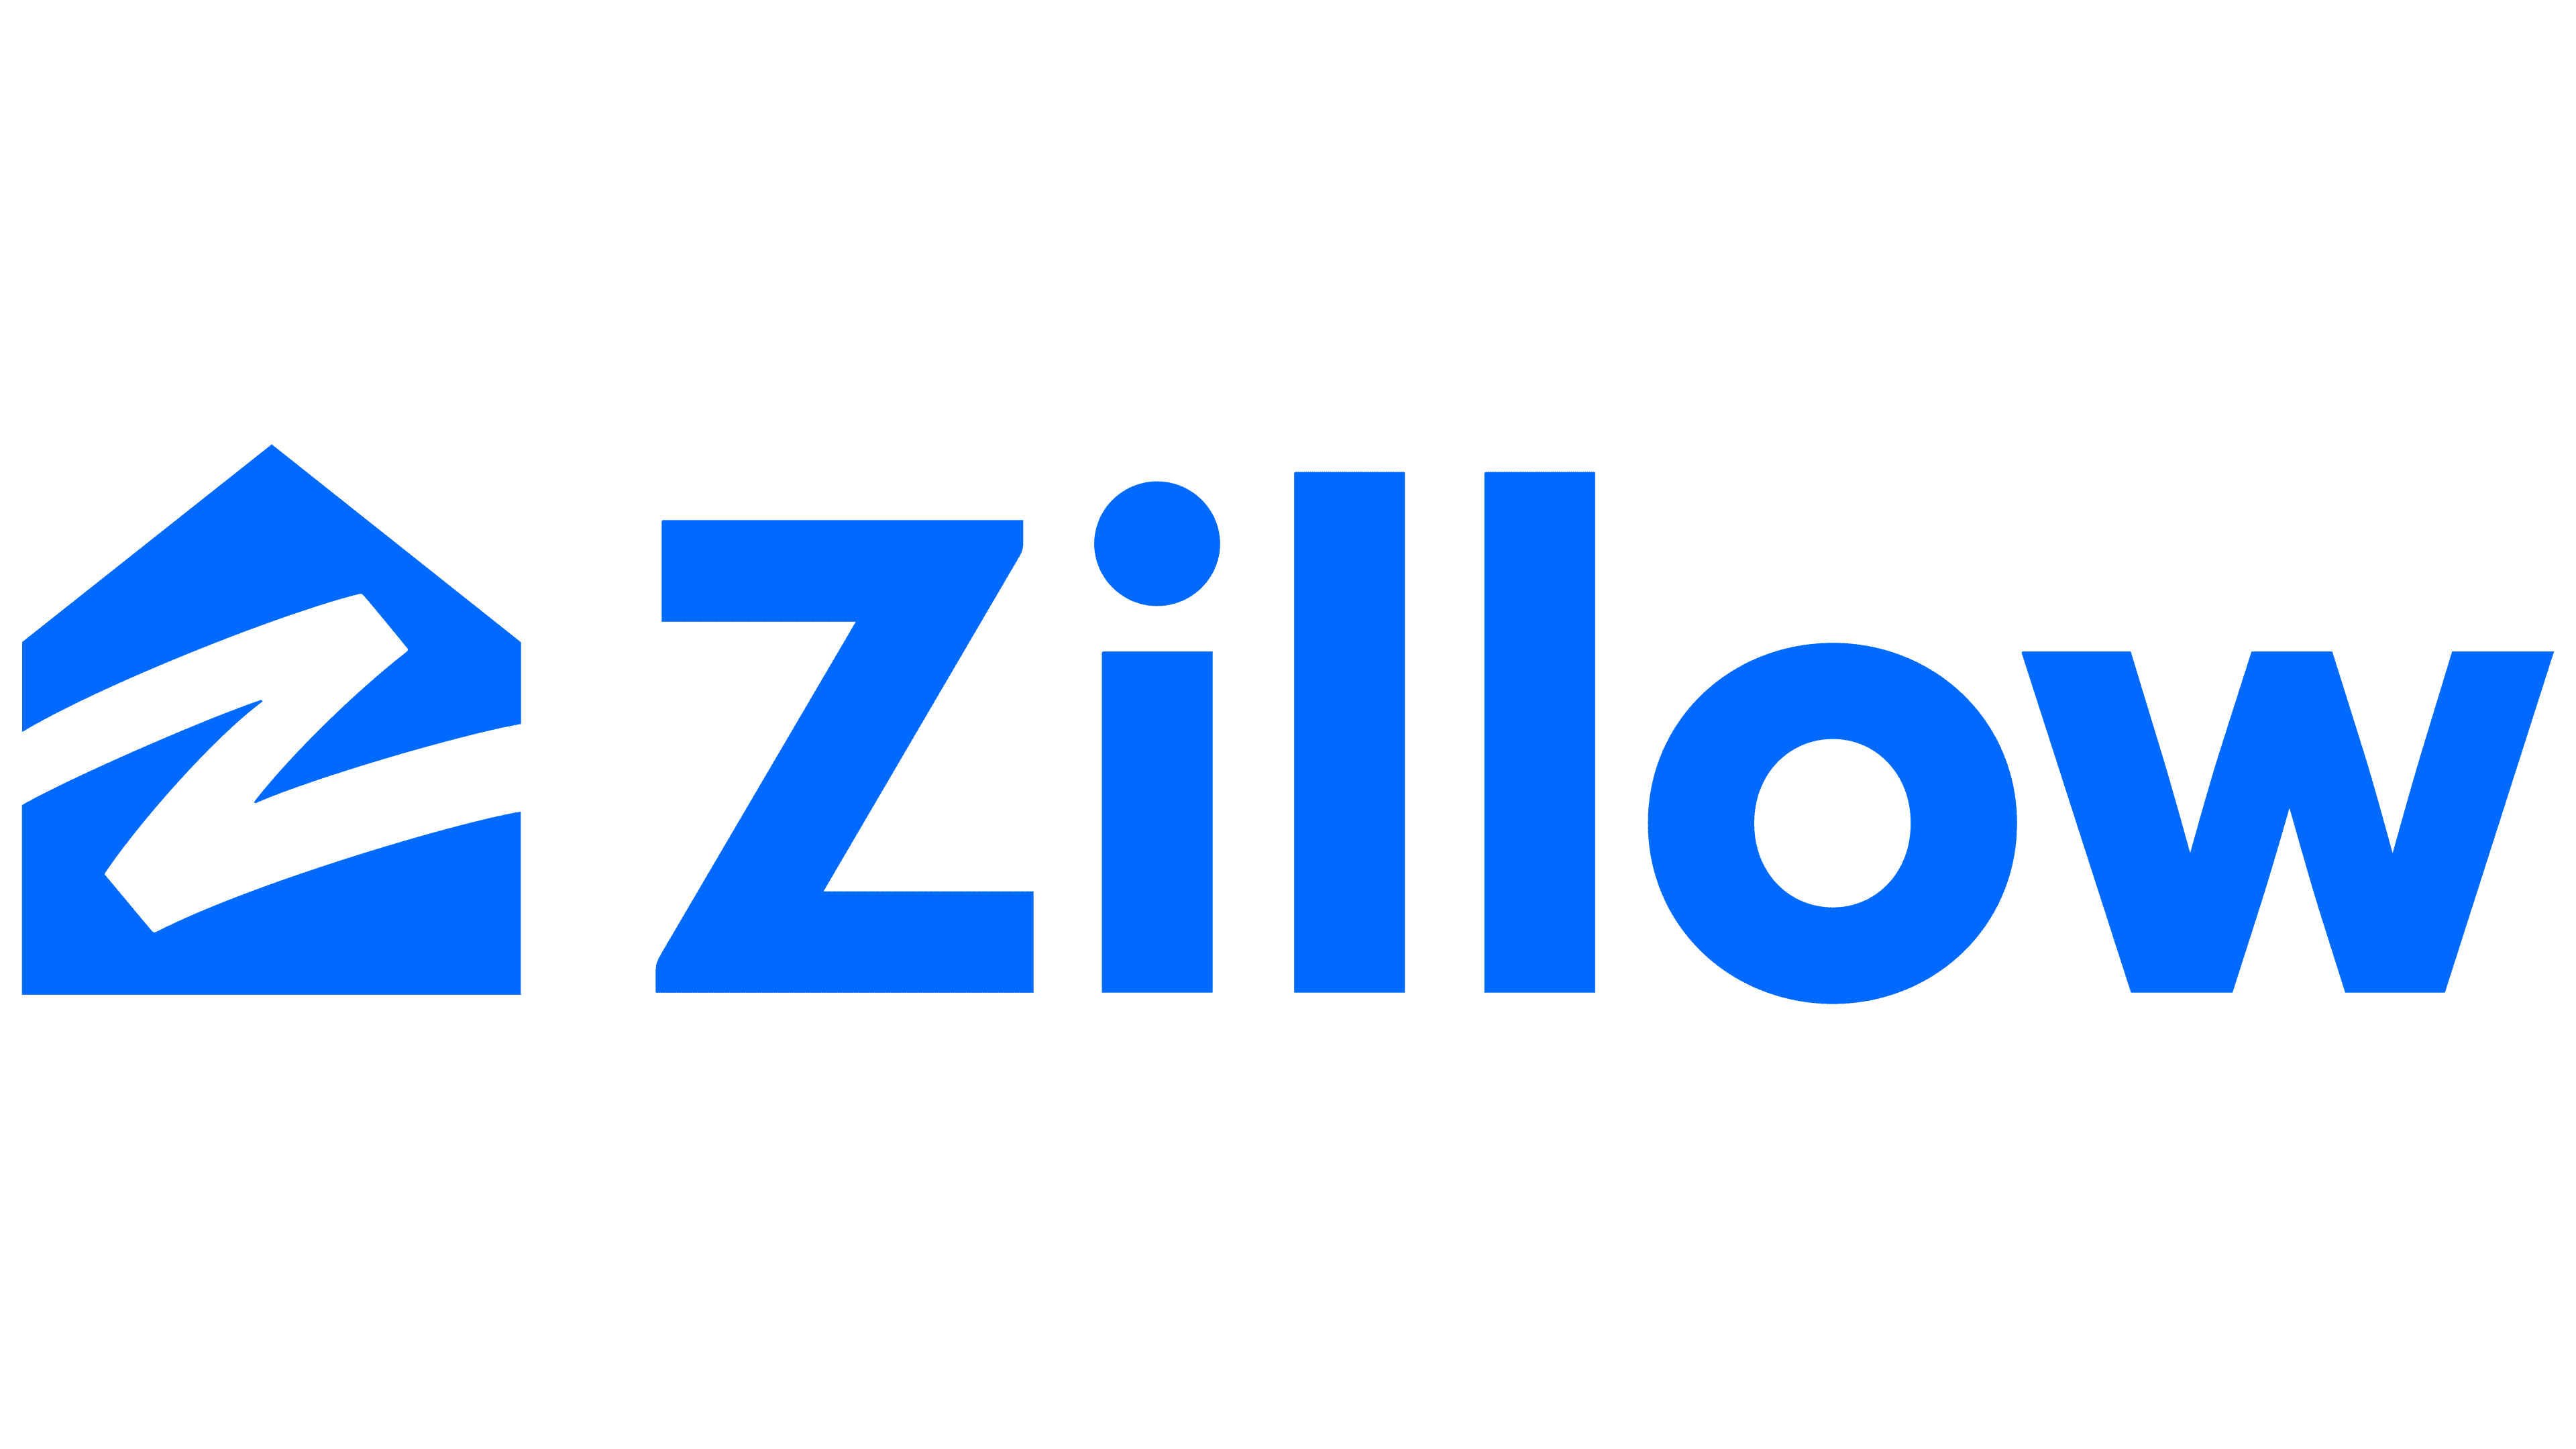

In [8]:
logo_chart = alt.Chart(data_brand_agg).mark_image(width = 80, height = 60).encode(
    x=alt.X('search_query', title='Brand', sort = '-y'),
    y=alt.Y('negativate_flag',  scale=alt.Scale(domain=[0, .5]),title=''),
    url = 'image'  # This is correct now
).properties(height = 400, width = 825, title = "Average Negative Propensity Score by Company")


brand_colors = brand_dict # Map brands to colors
color_scale = alt.Scale(domain=list(brand_colors.keys()), range=list(brand_colors.values())) 

bar_chart = alt.Chart(data_brand_agg).mark_bar(size = 50).encode(
    x=alt.X('search_query', title='Brand', sort = '-y', axis=alt.Axis(labels=False)),
    y=alt.Y('negativate_flag',  scale=alt.Scale(domain=[0, .62]),title='% of Posts Rated Negative'),
    color = alt.Color('search_query', scale=color_scale, legend=None) 
).properties(height = 400, width = 825, title = "% of Reddit Posts Rated as 'Negative' by the Open AI Model")

(bar_chart + logo_chart).configure_title(fontSize=28).configure_axis(
    labelFontSize=28,
    titleFontSize=28
).configure_axis(
    grid=False
).configure_view(
    stroke=None
)


In [9]:
# Group by month 
df['created_at'] = pd.to_datetime(df['created_at'])
df['year'] = pd.to_datetime(df['created_at']).dt.year
df['create_date'] = pd.to_datetime(df['created_at'].dt.strftime('%m-%Y'))


In [10]:
grouped_df = df.groupby(['search_query', 'create_date', 'year']).agg({'submission_id': 'count' ,'negativate_flag': 'sum'}).reset_index()

grouped_df['negativate_flag_smoothed'] = (
    grouped_df.groupby('search_query')['negativate_flag']
    .transform(lambda x: x.rolling(12, min_periods=6).mean())
)

grouped_df['submission_id_smoothed'] = (
    grouped_df.groupby('search_query')['submission_id']
    .transform(lambda x: x.rolling(12, min_periods=6).mean())
)

grouped_df = grouped_df[grouped_df['year'] >= 2023]

# If the number of submissions is too small, set to NA 
num_posts =  5 
grouped_df['negativate_flag_smoothed'] = np.where(grouped_df['submission_id_smoothed']<= num_posts, np.nan, grouped_df['negativate_flag_smoothed'])
grouped_df['submission_id_smoothed'] = np.where(grouped_df['submission_id_smoothed']<= num_posts, np.nan, grouped_df['submission_id_smoothed'])

# Calculate the percent negative
grouped_df['percent_negative'] = grouped_df['negativate_flag'] / grouped_df['submission_id']
grouped_df['percent_negative_smoothed'] = grouped_df['negativate_flag_smoothed'] / grouped_df['submission_id_smoothed']

grouped_df = grouped_df.sort_values(by='create_date', ascending=True)

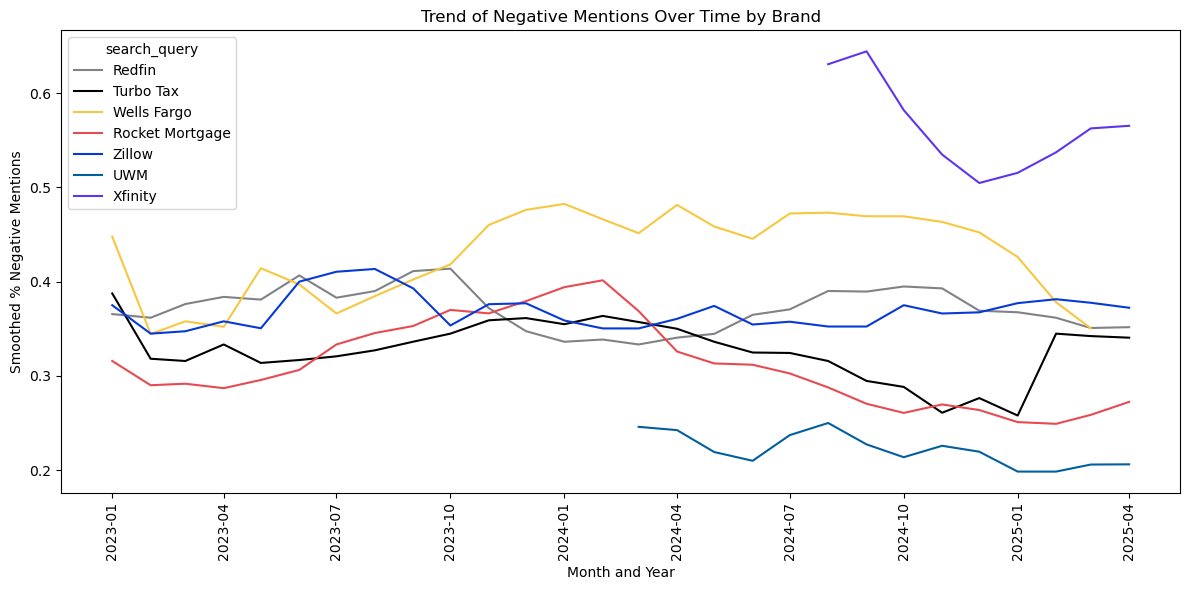

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt

brand_dictionary = {
    'Rocket Mortgage': '#e74a51',
    'UWM': '#025f9f',
    'Redfin': '#808286',
    'Zillow': '#0639d8',
    'Xfinity': '#5e34ef',
    'Turbo Tax': '#000000',
    'Wells Fargo': '#f6c83f'
}

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_df,
    x='create_date',
    y='percent_negative_smoothed',
    hue='search_query',
    palette=brand_dictionary,
    estimator='mean'
)

plt.xticks(rotation=90)
plt.xlabel('Month and Year')
plt.ylabel('Smoothed % Negative Mentions')
plt.title('Trend of Negative Mentions Over Time by Brand')
plt.tight_layout()
plt.show()


# XGBoost model scores to get the trends


## Load and combine data

These data location were done by running the models on the full dataset and outputting them into these locations.

In [12]:
from access_data import authenticate_google_drive, grab_google_drive_folder_data

drive = authenticate_google_drive()

# Load in data with embeddings
file_path = "multi-qa-mpnet_scores.csv"
data_mpnet  = grab_google_drive_folder_data(drive=drive,filename = file_path)

file_path = 'xgboost_bge_test_predictions.csv'
data_bge  = grab_google_drive_folder_data(drive=drive ,filename = file_path)

file_path = 'open_ai_labeled_responses.csv'
data_ai  = grab_google_drive_folder_data(drive=drive,filename = file_path)

Successfully loaded 'multi-qa-mpnet_scores.csv' into a DataFrame!
Successfully loaded 'xgboost_bge_test_predictions.csv' into a DataFrame!
Successfully loaded 'open_ai_labeled_responses.csv' into a DataFrame!


In [13]:
# Rename columns to keep track of which model each came from
mpnet_rename_dict = {'neutral':'neutral_mpnet', 'negative': 'negative_mpnet', 'positive': 'positive_mpnet', 'class_pred': 'class_pred_mpnet'}
data_mpnet =  data_mpnet.rename(mpnet_rename_dict, axis = 1)

bge_rename_dict = {'neutral':'neutral_bge', 'negative': 'negative_bge', 'positive': 'positive_bge', 'class_pred': 'class_pred_bge'}
data_bge =  data_bge.rename(bge_rename_dict, axis = 1)

In [14]:
# Join data together
data_joined = pd.merge(left = data_ai, 
         right = data_mpnet,
         how = 'left',
         on = ['submission_id', 'subredit_topic', 'search_query']
        )

data_joined = pd.merge(left = data_joined, 
                       right = data_bge,
                       how = 'left',
                       left_on = ['submission_id', 'subredit_topic', 'search_query'],
                       right_on = ['submission_id', 'subreddit_topic', 'search_query'],
        )

data_joined['model_avg_negative'] = data_joined[['negative_mpnet', 'negative_bge']].mean(axis=1)
data_joined['model_avg_neutral'] = data_joined[['neutral_mpnet', 'neutral_bge']].mean(axis=1)
data_joined['model_avg_positive'] = data_joined[['positive_bge', 'positive_bge']].mean(axis=1)

## Data manipulation for visualization 

In [15]:
# Extract negative ratings
cols = ['search_query', 'score', 'created_at', 'negative_mpnet', 'negative_bge']
data_trend = data_joined[cols]

# filter to only 2023 posts and beyond
data_trend['year'] = pd.to_datetime(data_trend['created_at']).dt.year
data_trend_filt = data_trend[data_trend['year'] >= 2023]

# Extract only meaningful columns
cols = ['search_query', 'score', 'created_at', 'negative_mpnet', 'negative_bge', 'year']
data_trend_filt = data_trend_filt[cols]

# Transform for easy visualization
data_trend_chart = data_trend_filt.melt(id_vars =['search_query', 'score', 'created_at', 'year'])

/var/folders/wp/393dmtxd2jd8sj2z2tt7jpm40000gn/T/ipykernel_5058/1019962241.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_trend['year'] = pd.to_datetime(data_trend['created_at']).dt.year


## Visualize the data

In [16]:
def create_trend_chart(brands, trend_dataset, brand_dict):  
    chart_list = []
    
    brand_colors = {brand: brand_dict[brand] for brand in brands}  # Map brands to colors
    color_scale = alt.Scale(domain=list(brand_colors.keys()), range=list(brand_colors.values()))  

    for brand in brands:
        single_company = trend_dataset[trend_dataset['search_query'] == brand]
        
        base = alt.Chart(single_company).mark_circle(opacity=0.2).encode(
            alt.X('created_at:T', axis=alt.Axis(format='%b, %Y'),title = "Date of the Reddit Post"),
            alt.Y('value', title = "Negative Rating Model Score"),
            alt.Color('search_query', scale=color_scale, legend=alt.Legend(title="Brand"))  
        ).properties(height=400, width=850, title = {"text": "Average Negativity Score per Reddit Post by Company"
                                                   , "subtitle": 'January 2023 - March 2025'}
        )	        
        
        trend_line = base.transform_loess('created_at', 'value', groupby=['search_query']).mark_line(
            size=4, opacity=0.8
        )
        
        chart_list.append(base + trend_line)  # Combine scatter plot and trend line

    return chart_list

In [17]:
# Brand dictionary
brand_dictionary = {'Rocket Mortgage' : '#e74a51',
                    'UWM': '#025f9f',
                    'Redfin': '#c82020',
                    'Zillow': '#0639d8',
                    'Xfinity': '#5e34ef',
                    'Turbo Tax': '#d02a1d',
                    'Wells Fargo': '#f6c83f'}

all_brands = data_mpnet['search_query'].unique()
my_brands = ['Rocket Mortgage', 'UWM', 'Xfinity', 'Wells Fargo']


charts = create_trend_chart(my_brands, data_trend_chart, brand_dictionary)

alt.layer(*charts).configure_title(fontSize=24, subtitleFontSize = 16).configure_axis(
    labelFontSize=12,
    titleFontSize=15,
    grid=False
).configure_view(
    stroke=None
).configure_legend(
    strokeColor='gray',
    fillColor='#EEEEEE',
    padding=10,
    cornerRadius=10,
    orient='top-left'
).configure_axis(
    labelFontSize=20,
    titleFontSize=18
)

alt.LayerChart(...)